## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.linear_model import LogisticRegression

## Hyperparameters and Directories

In [2]:
data = 'Pokemon.csv'

SEED = 123
EPOCH = 100000
LEARNING_RATE = 1e-1    # 0.1

## Data Loading and Pre-processing

### Import dataset

In [3]:
df = pd.read_csv('Pokemon.csv')

## Exploratory data analysis

In [4]:
print(f"Found {df.shape[0]} samples with {df.shape[1]} features")

Found 800 samples with 13 features


#### Let's preview the dataset

In [5]:
df.head()

#                   Name Type 1  Type 2  Total  HP  Attack  Defense  \
0  1              Bulbasaur  Grass  Poison    318  45      49       49   
1  2                Ivysaur  Grass  Poison    405  60      62       63   
2  3               Venusaur  Grass  Poison    525  80      82       83   
3  3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123   
4  4             Charmander   Fire     NaN    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       65       65     45           1      False  
1       80       80     60           1      False  
2      100      100     80           1      False  
3      122      120     80           1      False  
4       60       50     65           1      False

#### Now let's view the columns

In [6]:
col_names = df.columns

col_names

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

#### Check distribution of target_class column

In [7]:
df['Legendary'].value_counts()

Legendary
False    735
True      65
Name: count, dtype: int64

#### View summary of the dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


#### Check of missing value

In [9]:
df.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

Type 2 missing is normal, not all pokemon has secondary type

### Remove Mega Evolution Pokemon

In [10]:
df = df[~df['Name'].str.contains('Mega ')]

### Remove unused features

In [11]:
# df.drop(columns=['#', 'Name', 'Type 1', 'Type 2'],inplace=True)
df = pd.DataFrame(df, columns=['Total', 'Legendary'])

df

Total  Legendary
0      318      False
1      405      False
2      525      False
4      309      False
5      405      False
..     ...        ...
794    600       True
795    600       True
797    600       True
798    680       True
799    600       True

[752 rows x 2 columns]

### Declare feature vector and target variable

In [12]:
X = df.drop('Legendary', axis=1)  # Drop the target column from features
y = df['Legendary']  # Target column containing labels

### Split data into separate training and test set

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

In [14]:
y_train.value_counts()

Legendary
False    554
True      47
Name: count, dtype: int64

### Data Points

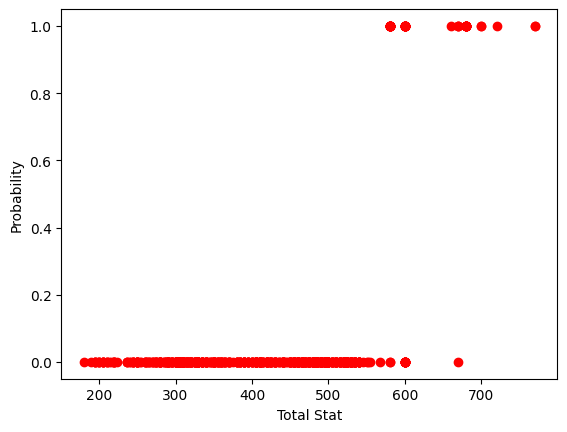

In [15]:
plt.plot(X, y, 'ro')
plt.xlabel('Total Stat')
plt.ylabel('Probability')
plt.show()

## Training

### Function and Class

In [16]:
class LogisticRegression:
    # Class constructor
    def __init__(self, alpha=1, iteration=1500):
        self.w = None   # Weights
        self.b = 0      # Bias
        self.n = None   # No. of samples
        self.X = None
        self.y = None
        # Define the learning rate
        self.alpha = alpha
        # Define the iteration number
        self.iteration = iteration
        # Scaling factor is used to scale down big feature
        self.scaling_factor = 1
        self.losses = []

    def find_scaling_factor(self):
        min_feature = int(np.min(self.X))
        # Check the number of digits in the minimum input value
        num_digits = len(str(min_feature))
        # Determine the scaling factor based on the number of digits
        scaling_factor = 10 ** (num_digits - 1)

        return scaling_factor

    def sigmoid(self, z):
        return 1 / (1 + 1 / np.exp(z))
    
    def likelihood(self, X, w, b):
        # Feature scaling
        X = X / self.scaling_factor
        z = np.dot(X, w) + b
        y_prob = self.sigmoid(z)
        return y_prob

    # Class function to fit the data (find the appropiate value of w)
    def fit(self, X, y):
        # Feature scaling
        self.X = X
        self.y = y

        # Number of samples & number of features (dimensions)
        self.n, d = X.shape

        self.scaling_factor = self.find_scaling_factor()

        # Initialize w
        self.w = np.zeros(d)

        # Gradient Descent
        for i in range(self.iteration):
            print(f"Epoch {i+1}/{self.iteration}")
            # Stop when overshot
            if not self.epoch():
                print("Reached minimum loss")
                break

    def epoch(self):
        w_current = self.w
        b_current = self.b  

        # Compute gradients
        dw, db = self.compute_gradient(w_current, b_current)      
        step_w = -self.alpha * dw
        step_b = -self.alpha * db

        # Update weights and bias
        w_update = w_current + step_w
        b_update = b_current + step_b

        current_loss = self.log_loss(w_current, b_current)
        update_loss = self.log_loss(w_update, b_update)

        self.losses.append(update_loss)
        
        if current_loss > update_loss:
            print(f"Log loss: {update_loss}")
            self.w = w_update
            self.b = b_update
            return True
        else:
            print(f"Log loss: {update_loss} (increased)")
            return False

    def compute_gradient(self, w_current, b_current):
        y_prob = self.likelihood(self.X, w_current, b_current)
        X = self.X / self.scaling_factor

        # Compute gradients
        dw = (1 / self.n) * np.dot(X.transpose(), (y_prob - self.y))
        db = (1 / self.n) * np.sum(y_prob - self.y)

        return dw, db
    
    def log_loss(self, w, b):
        y_prob = self.likelihood(self.X, w, b)

        loss = (-1 / self.n) * np.sum(self.y * np.log(y_prob)           # if y = 1
                              + (1 - self.y) * np.log(1 - y_prob))      # if y = 0
        return loss

    def predict(self, X):
        y_prob = self.likelihood(X, self.w, self.b)
        y_pred = [1 if p >= 0.5 else 0 for p in y_prob]
        return np.array(y_pred)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy
    
    def get_losses(self):
        return self.losses



### Fitting

In [17]:
h = LogisticRegression(alpha=LEARNING_RATE, iteration=EPOCH)
h.fit(X_train, y_train)

Epoch 1/100000
Log loss: 0.4817667165271192
Epoch 2/100000
Log loss: 0.41907481352919
Epoch 3/100000
Log loss: 0.3941622481592606
Epoch 4/100000
Log loss: 0.3822573558025435
Epoch 5/100000
Log loss: 0.3758891482891941
Epoch 6/100000
Log loss: 0.3722052630608341
Epoch 7/100000
Log loss: 0.36993829657918587
Epoch 8/100000
Log loss: 0.3684644721867191
Epoch 9/100000
Log loss: 0.3674537788251124
Epoch 10/100000
Log loss: 0.3667221324506154
Epoch 11/100000
Log loss: 0.36616268014275327
Epoch 12/100000
Log loss: 0.3657114775850473
Epoch 13/100000
Log loss: 0.3653293401783152
Epoch 14/100000
Log loss: 0.3649918042100948
Epoch 15/100000
Log loss: 0.3646833692870546
Epoch 16/100000
Log loss: 0.3643940979132928
Epoch 17/100000
Log loss: 0.3641175586475717
Epoch 18/100000
Log loss: 0.36384955743533126
Epoch 19/100000
Log loss: 0.36358734247914265
Epoch 20/100000
Log loss: 0.36332909932273844
Epoch 21/100000
Log loss: 0.3630736267601044
Epoch 22/100000
Log loss: 0.3628201269705995
Epoch 23/100000


### Plot Loss Function

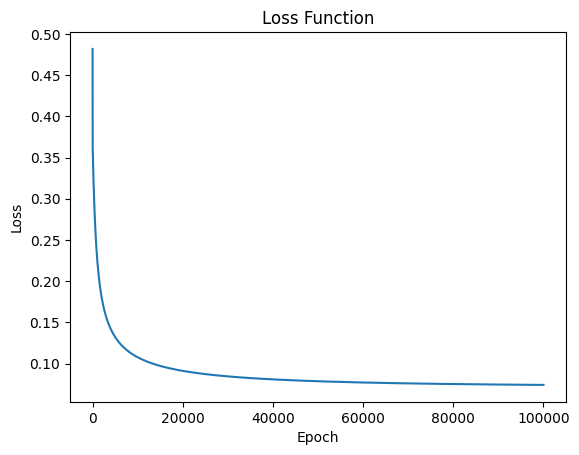

In [18]:
epoch = pd.DataFrame(list(range(1,EPOCH+1,1)))
loss = pd.DataFrame(h.get_losses())
loss_data = pd.concat([epoch, loss], axis=1)
loss_data.columns = ['Epoch','Loss']
plt.plot(loss_data['Epoch'], loss_data['Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Function')
plt.show()

## Evaluation

### Weight and Bias Result

In [19]:
h.w

array([4.64286148])

In [20]:
h.b

-27.288996399743876

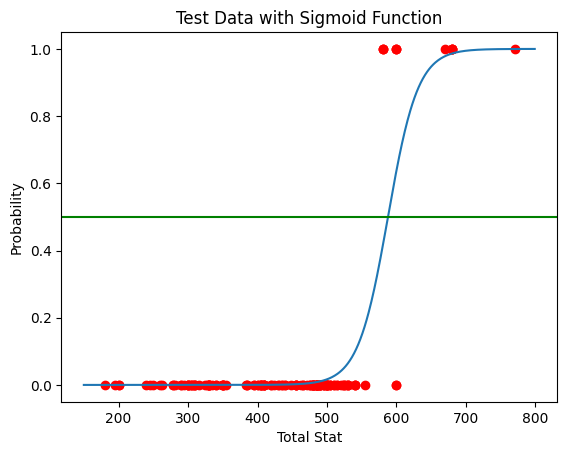

In [21]:
# Plot the probability curve
plt.plot(X_test, y_test, 'ro')
plt.plot(np.array([np.arange(start=150, stop=800, step=1)]).T, h.likelihood(np.array([np.arange(start=150, stop=800, step=1)]).T, h.w, h.b))
plt.axhline(y = 0.5, color = 'g')
plt.xlabel('Total Stat')
plt.ylabel('Probability')
plt.title('Test Data with Sigmoid Function')
plt.show()

### Test Accuracy

In [22]:
score = round(h.score(X_test, y_test)*100, 2)
print("The accuracy score we have achieved using Logistic Regression is: "+str(score)+" %")

The accuracy score we have achieved using Logistic Regression is: 96.69 %
